- Formulate a hypothesis?
- Split data set and perform exploratory analysis on first, confirm with the second
- is the data an unbiased representation of the population?

In [16]:
import pandas as pd
from scipy import stats
import numpy as np

# Read the dataset
df = pd.read_csv('processed/df.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      340 non-null    float64
 1   blood_pressure           337 non-null    float64
 2   specific_gravity         302 non-null    object 
 3   albumin                  303 non-null    object 
 4   sugar                    300 non-null    object 
 5   red_blood_cells          200 non-null    object 
 6   pus_cell                 287 non-null    object 
 7   pus_cell_clumps          345 non-null    object 
 8   bacteria                 345 non-null    object 
 9   blood_glucose_random     306 non-null    float64
 10  blood_urea               331 non-null    float64
 11  serum_creatinine         332 non-null    float64
 12  sodium                   263 non-null    float64
 13  potassium                262 non-null    float64
 14  hemoglobin               2

# 1. Introduction

This chapter aims to interpret the statistical significance of various health indicators as they pertain to kidney disease classification. Using a dataset of kidney disease patients, an analysis of variance (ANOVA) was conducted on numerical data such as age, blood pressure, blood glucose, blood urea, serum creatinine, sodium, potassium, hemoglobin, packed cell volume, white blood cell count, and red blood cell count.

ANOVA is a statistical method used to test differences between two or more means. It may seem that it is limited to comparing the means of only two groups, but it is actually quite versatile. ANOVA can handle any number of groups and even handle different group sizes gracefully. It does this by comparing the means of each group to the mean of all groups combined.

# 2. ANOVA

In [29]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Read the dataset
df = pd.read_csv('processed/df.csv')

# Rename 'class' column to 'class_label' 
df = df.rename(columns={'class': 'class_label'})

# Convert boolean 'class_label' column to string because statsmodels works better with string categoricals
df['class_label'] = df['class_label'].apply(str)

# List of numerical columns
numerical_cols = ['age', 'blood_pressure', 'blood_glucose_random', 'blood_urea',
                  'serum_creatinine', 'sodium', 'potassium', 'hemoglobin', 
                  'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count']

# Perform the ANOVA for each numerical column
for col in numerical_cols:
    # Drop NaN values for the current column
    df_dropna = df[[col, 'class_label']].dropna()

    # Perform OLS regression
    model = ols(f'{col} ~ C(class_label)', data=df_dropna).fit()

    # Perform ANOVA and print the table
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"For column '{col}':")
    print(anova_table)
    print("-----------------")


For column 'age':
                      sum_sq     df          F        PR(>F)
C(class_label)   6919.172167    1.0  25.629952  6.809123e-07
Residual        91247.933716  338.0        NaN           NaN
-----------------
For column 'blood_pressure':
                      sum_sq     df          F        PR(>F)
C(class_label)   4860.245151    1.0  26.043498  5.604911e-07
Residual        62517.796392  335.0        NaN           NaN
-----------------
For column 'blood_glucose_random':
                      sum_sq     df          F        PR(>F)
C(class_label)  2.653726e+05    1.0  44.397379  1.257993e-10
Residual        1.817072e+06  304.0        NaN           NaN
-----------------
For column 'blood_urea':
                       sum_sq     df          F        PR(>F)
C(class_label)  108754.481374    1.0  43.591567  1.623396e-10
Residual        820806.104668  329.0        NaN           NaN
-----------------
For column 'serum_creatinine':
                      sum_sq     df          F    PR(>F

In [30]:
# Collect p-values
p_values = {}
for col in numerical_cols:
    df_dropna = df[[col, 'class_label']].dropna()
    model = ols(f'{col} ~ C(class_label)', data=df_dropna).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_values[col] = anova_table['PR(>F)'][0]

# Convert to -log10 scale
for key, val in p_values.items():
    p_values[key] = -np.log10(val)


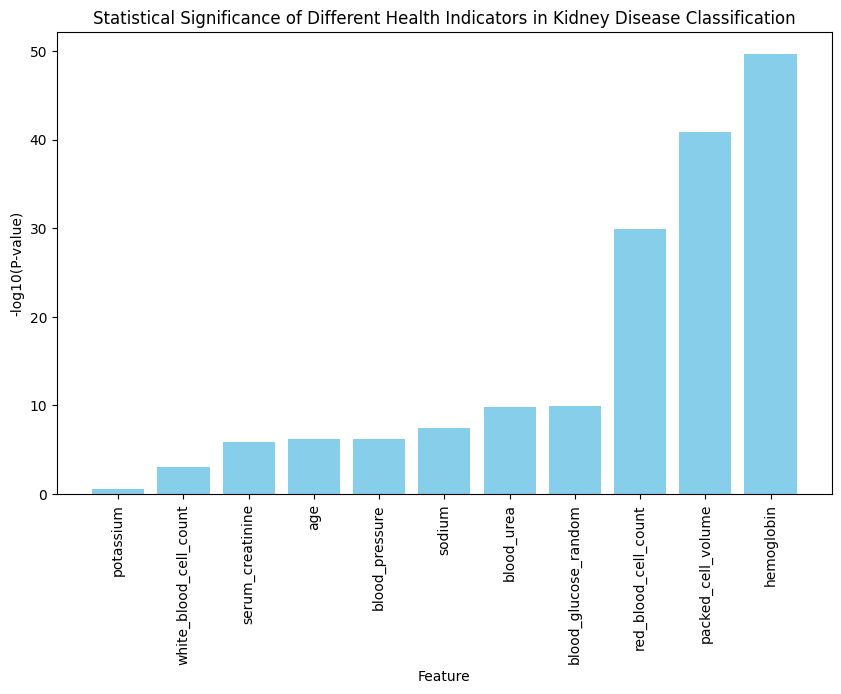

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by p-value
sorted_p_values = dict(sorted(p_values.items(), key=lambda item: item[1]))

# Create a bar plot
plt.figure(figsize=(10,6))
plt.bar(range(len(sorted_p_values)), list(sorted_p_values.values()), align='center', color='skyblue')
plt.xticks(range(len(sorted_p_values)), list(sorted_p_values.keys()), rotation=90)
plt.xlabel('Feature')
plt.ylabel('-log10(P-value)')
plt.title('Statistical Significance of Different Health Indicators in Kidney Disease Classification')
plt.show()


Starting with 'age', it can be seen from the ANOVA table that age does play a significant role in classifying kidney disease, with a p-value much less than 0.05. This means that there is a significant difference in age across the two classes of kidney disease. This might be an indication that age is a risk factor for kidney disease, with older individuals being more prone to this condition.

Moving on to blood pressure, the F-value is high, and the p-value is less than 0.05. This suggests that blood pressure is statistically significant in the diagnosis of kidney disease. Higher or lower blood pressure might affect kidney function, leading to the development of kidney diseases.

Blood glucose random and blood urea also follow the same pattern, with high F-values and very small p-values, implying that they are statistically significant. These indicators could be related to the patient's diet or metabolic function, which, when dysregulated, can impact kidney function negatively.

Serum creatinine levels show a strong association with the kidney disease classification, given the very small p-value. Creatinine is a waste product that your kidneys should remove, so high levels might indicate poor kidney function.

Sodium levels also play a significant role in kidney disease classification as indicated by the F-value and the p-value. The kidneys regulate the amount of sodium in the body, and abnormal levels might reflect disease.

However, it's interesting to note that the 'potassium' variable is not statistically significant in this model, given its p-value is above the common threshold of 0.05. This could suggest that potassium levels aren't a reliable indicator of kidney disease in this dataset.

Hemoglobin, packed cell volume, and red blood cell count all show very high F-values and tiny p-values, indicating a very strong statistical significance. This could suggest anemia is common in kidney disease patients, as the kidneys stimulate red blood cell production, and lower values might indicate disease.

Lastly, while the white blood cell count is significant, the p-value isn't as tiny as some of the other variables, suggesting it might be less of a key factor than others.

# 3. Conclusion

In conclusion, age, blood pressure, blood glucose random, blood urea, serum creatinine, sodium, hemoglobin, packed cell volume, white blood cell count, and red blood cell count all appear to be significant factors in determining kidney disease classification. Potassium was not found to be significant in this dataset. It's crucial to note that while this analysis provides insight into potential relationships, it doesn't prove causation. Further investigation would be required to confirm these findings and understand the underlying biological mechanisms. Also, the ability of these factors to predict kidney disease could be improved by considering interaction terms or using more complex statistical models. This dataset and statistical modelling approach provide a good starting point for understanding the factors influencing kidney disease.

/var/folders/cx/xl_9kf9545z_ymklklcg58q00000gn/T/ipykernel_20344/2159820115.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['class_label'] = df_dropna['class_label'].apply(lambda x: True if x=='True' else False)


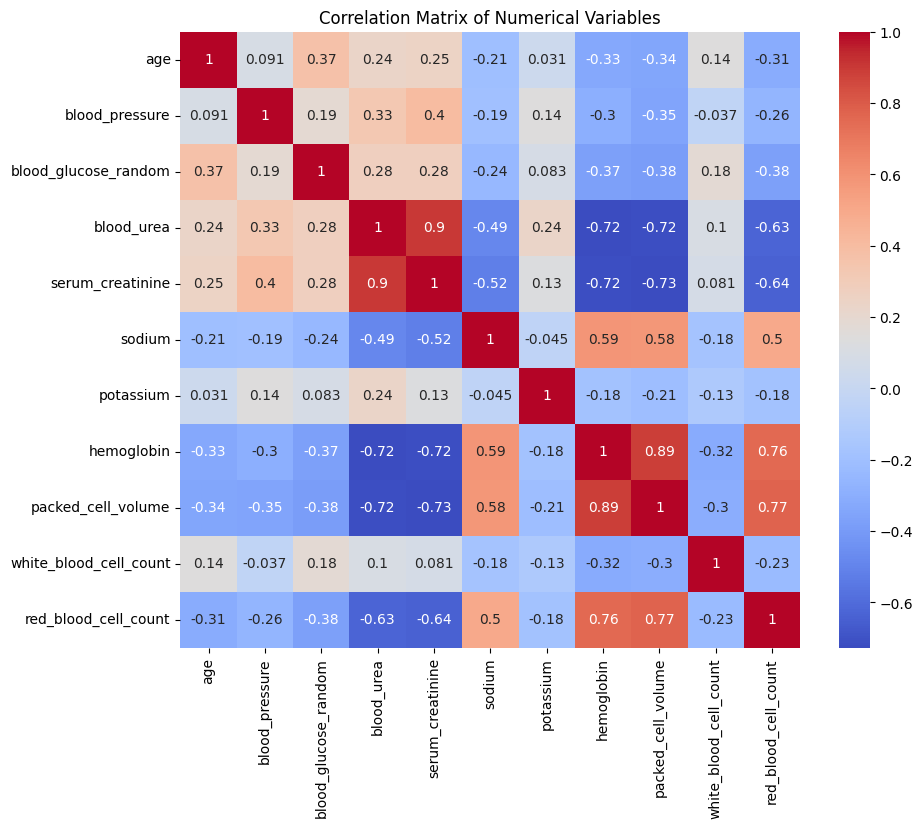

Classification Report:
              precision    recall  f1-score   support

       False       0.95      1.00      0.98        21
        True       1.00      0.92      0.96        13

    accuracy                           0.97        34
   macro avg       0.98      0.96      0.97        34
weighted avg       0.97      0.97      0.97        34

Confusion Matrix:
[[21  0]
 [ 1 12]]


/var/folders/cx/xl_9kf9545z_ymklklcg58q00000gn/T/ipykernel_20344/2159820115.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna[column] = le.fit_transform(df_dropna[column])
/var/folders/cx/xl_9kf9545z_ymklklcg58q00000gn/T/ipykernel_20344/2159820115.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna[column] = le.fit_transform(df_dropna[column])
/var/folders/cx/xl_9kf9545z_ymklklcg58q00000gn/T/ipykernel_20344/2159820115.py:26: SettingWithCopyWarning: 
A value is trying to be set on a c

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Drop NaN values
df_dropna = df.dropna()

# Convert boolean 'class_label' column back to boolean because sklearn works better with boolean targets
df_dropna['class_label'] = df_dropna['class_label'].apply(lambda x: True if x=='True' else False)

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_dropna[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Logistic Regression

# Convert categorical variables to numerical
le = LabelEncoder()
for column in df_dropna.columns:
    if df_dropna[column].dtype == 'object':
        df_dropna[column] = le.fit_transform(df_dropna[column])

# Split into train and test sets
X = df_dropna.drop('class_label', axis=1)
y = df_dropna['class_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions and print out the classification report
y_pred = lr.predict(X_test)
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print out the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


# Confidence Intervalls

In [36]:
# Read the dataset
df = pd.read_csv('processed/df_numeric.csv')

In [37]:
from scipy import stats

# Calculate confidence intervals for each numerical column
for col in df.columns:
    if col != 'class_label':
        # Drop NaN values for the current column
        df_dropna = df[[col]].dropna()
        ci = stats.t.interval(0.95, len(df_dropna)-1, loc=df_dropna.mean(), scale=stats.sem(df_dropna))
        print(f"For column '{col}', Confidence Interval is: {ci}")
        print("-----------------")


For column 'age', Confidence Interval is: (array([49.85530224]), array([53.48587423]))
-----------------
For column 'blood_pressure', Confidence Interval is: (array([75.69331818]), array([78.72804681]))
-----------------
For column 'specific_gravity', Confidence Interval is: (array([1.01584173]), array([1.01710529]))
-----------------
For column 'albumin', Confidence Interval is: (array([1.03087385]), array([1.34536377]))
-----------------
For column 'sugar', Confidence Interval is: (array([0.39349203]), array([0.6598413]))
-----------------
For column 'red_blood_cells', Confidence Interval is: (array([0.70572993]), array([0.82427007]))
-----------------
For column 'pus_cell', Confidence Interval is: (array([0.6838378]), array([0.78654548]))
-----------------
For column 'pus_cell_clumps', Confidence Interval is: (array([0.08706334]), array([0.15641492]))
-----------------
For column 'bacteria', Confidence Interval is: (array([0.03785659]), array([0.08967964]))
-----------------
For col

# Multivariate Regression

In [42]:
_numeric.csv')

# Rename 'class' column to 'class_label' 
df_numeric = df_numeric.rename(columns={'class': 'class_label'})

# Convert boolean 'class_label' column to string because statsmodels works better with string categoricals
df_numeric['class_label'] = df_numeric['class_label'].apply(str)

# Drop NaN values
df_numeric = df_numeric.dropna()

# Convert boolean 'class_label' column back to boolean because sklearn works better with boolean targets
df_numeric['class_label'] = df_numeric['class_label'].apply(lambda x: True if x=='True' else False)


# Separate the independent variables (everything except 'class_label') and the dependent variable
X = df_numeric.drop('class_label', axis=1)
y = df_numeric['class_label']

# Create a formula for statsmodels
formula = 'class_label ~ ' + ' + '.join([f'Q("{col}")' for col in X.columns])

# Perform multivariate regression and print the summary
model = smf.ols(formula, data=df_numeric).fit()
print(model.summary())


ValueError: endog has evaluated to an array with multiple columns that has shape (113, 2). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).